# Modelling walkthrough

The purpose of this notebook is to show how a new, sample model with custom dependencies would be developed and integrated into the pipeline.

This notebook follows a hypothetical scenario where Machine Learning Engineer Maya is developing a new model, with the aim of generating her own predictions of drug-disease treatment efficacy scores. Maya is new to the EveryCure / Matrix ecosystem, and is learning as she goes.

In the end, she wants to train and submit a new model to the pipeline, and have it evaluated along with the other models.

## Modelling assumptions

Maya's goal is to train a new model that will predict the efficacy of drug-disease interactions.

**Embeddings from Knowledge Graph:** Maya knows that EveryCure has generated embeddings for biomedical knowledge graph nodes, which meaningfully encode semantics of the nodes. Many of those nodes are drugs and diseases between which she wants to predict treatment efficacy.

**Training Data:** Maya expects the training data to be a set of known positives and negatives, i.e. drug-disease pairs for which the treatment is known to be effective or ineffective.

**Evaluation:** Maya assumes that the model will be evaluated using AUC-ROC. She also assumes that she will need to perform train-validation splits on her data, and that Matrix's pipeline downstream will be able to further test the predictions of her model.

**Retrieving Data:** Importantly, Maya will retrieve the embeddings and training data from pipelines other than the modelling pipeline. She will avoid preprocessing the data itself as much as possible, relying on other resources provided by EveryCure.


# Prerequesites

Maya needs access to the GCS bucket containing the data (currently, `gs://mtrx-us-central1-hub-dev-storage`). Maya will use `gsutil` to copy the data to her local machine, and will find the exact paths to the files in the Kedro Data Catalog.

## Required data sources

### Embeddings 

Maya will use the embeddings generated by the Knowledge Graph pipeline to encode the drugs and disease into a vector space.

In the embeddings pipeline, embeddings are extracted from Neo4j and saved to GCS. The pipeline is defined in the [embeddings pipeline](https://github.com/matrix-ml/matrix/blob/main/pipelines/matrix/src/matrix/pipelines/embeddings/pipeline.py). 

```python
node(
    func=nodes.extract_node_embeddings,
    inputs={
        "nodes": "embeddings.model_output.graphsage",
        "string_col": "params:embeddings.write_topological_col",
    },
    outputs="embeddings.feat.nodes",
    name="extract_nodes_edges_from_db",
    tags=[
        "argowf.fuse",
        "argowf.fuse-group.topological_embeddings",
        "argowf.template-neo4j",
    ],
),
```

Kedro Dataset to which the embeddings are saved: 

```yml
embeddings.feat.nodes:
  <<: *_spark_parquet
  filepath: ${globals:paths.embeddings}/feat/nodes_with_embeddings
```


Maya knows that `${globals:paths.embeddings}/feat/nodes_with_embeddings` converts to `gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings`.

She arbitrarily chooses to use the latest version of the embeddings, which happens to be `v0.2.4-rc.1`. She will run the command below to copy the data to her local machine.

The files take up about 24GB of space.

In [ ]:
!python --version


In [ ]:
!mkdir -p data

!mkdir -p data/pca_embeddings

!gsutil -m cp \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/_SUCCESS" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00000-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00001-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00002-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00003-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00004-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00005-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00006-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00007-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00008-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00009-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00010-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00011-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00012-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00013-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00014-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/releases/v0.2.4-rc.1/datasets/embeddings/feat/nodes_with_embeddings/part-00015-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet" \
  data/embeddings/
  

### Ground truth data

Maya needs to retrieve the training data from the preprocessing pipeline, containing True / False positives and negatives that she can use to train her model on the previously retrieved embeddings. First input to other modelling pipelines is `modelling.raw.ground_truth.positives@spark`, so Maya will retrieve that dataset first (together with its negative counterpart `modelling.raw.ground_truth.negatives@spark`).

```python
node(
    func=nodes.create_int_pairs,
    inputs=[
        "embeddings.feat.nodes",
        "modelling.raw.ground_truth.positives@spark",
        "modelling.raw.ground_truth.negatives@spark",
    ],
    outputs="modelling.int.known_pairs@spark",
    name="create_int_known_pairs",
),
```

We retrieve ground truth data (conflated True Positives and True Negatives) from GCS. Both were produced by the `preprocessing` pipeline, as dataset `modelling.raw.ground_truth.positives@pandas` and `modelling.raw.ground_truth.negatives@pandas`, and will be read in as `@spark` dataframes by modelling steps. Maya will run the command below to copy the data to her local machine. Like in the previous step, the used version is arbitrary.

Maya sees that other files live alongside the `*_conflated.tsv` files, and decides to download and investigate them.

In [ ]:
!mkdir -p data/known_pairs

!gsutil -m cp \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/01_raw/ground_truth/translator/v2.7.3/tn_pairs_conflated.tsv" \
  "gs://mtrx-us-central1-hub-dev-storage/kedro/data/01_raw/ground_truth/translator/v2.7.3/tp_pairs_conflated.tsv" \
  data/known_pairs/


# Preprocessing

By now, Maya has obtained the embeddings and ground truth data. She will now preprocess the data to create the input for her model. She will also need to create splits for cross-validation.

Maya will first inspect the ground truth data.

In [2]:
import pandas as pd
# True positives
df_tp = pd.read_csv("data/known_pairs/tp_pairs_conflated.tsv", sep="\t")
df_tp.head()

,source,target
0,CHEBI:3699,MONDO:0007186
1,UNII:84H8Z9550J,MONDO:0007186
2,CHEBI:7915,MONDO:0007186
3,CHEBI:6375,MONDO:0007186
4,CHEBI:33130,MONDO:0007186


In [3]:
# True negatives

df_tn = pd.read_csv("data/known_pairs/tn_pairs_conflated.tsv", sep="\t")
df_tn.head()


,source,target
0,CHEBI:32149,MONDO:0006807
1,CHEBI:32588,MONDO:0006807
2,CHEBI:6804,MONDO:0007186
3,CHEBI:8094,MONDO:0007186
4,CHEMBL.COMPOUND:CHEMBL1187846,MONDO:0007186


True positives and true negatives are represented as sets of source-target pairs. `source` is the drug, `target` is the disease.

Now, Maya will inspect the embeddings that will be used as featured for her model.


In [4]:
import os

raw_embeddings_directory = 'data/embeddings'
sample_file_name = "part-00000-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet"
df= pd.read_parquet(os.path.join(raw_embeddings_directory, sample_file_name))

df.head()

,<id>,<labels>,topological_embedding,pca_embedding,id,category
0,0,[Entity],"[-0.030589668, 0.10044213, 0.19094326, 0.16870...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ATC:L01XY01,biolink:Drug
1,1,[Entity],"[0.3552283, 0.15644005, -0.07593296, 0.6228076...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AEO:0000187,biolink:AnatomicalEntity
2,2,[Entity],"[0.02153505, 0.3099397, 0.038633507, 0.0247304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AraPort:AT1G01720,biolink:Gene
3,3,[Entity],"[0.2947414, 0.15319654, 0.2776162, 0.40766323,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ATC:A07XA02,biolink:ChemicalEntity
4,4,[Entity],"[-0.057893604, 0.02334209, 0.040926114, 0.1583...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ATC:M01AX04,biolink:ChemicalEntity


In [5]:
df["category"].unique()

array(['biolink:Drug', 'biolink:AnatomicalEntity', 'biolink:Gene',
       'biolink:ChemicalEntity', 'biolink:SequenceVariant',
       'biolink:MolecularEntity', 'biolink:SmallMolecule',
       'biolink:Polypeptide', 'biolink:NucleicAcidEntity',
       'biolink:MolecularMixture', 'biolink:BiologicalEntity',
       'biolink:Protein', 'biolink:OrganismTaxon', 'biolink:CellLine',
       'biolink:Cell', 'biolink:Disease', 'biolink:PhenotypicFeature',
       'biolink:BiologicalProcess', 'biolink:Transcript',
       'biolink:MolecularActivity', 'biolink:CellularComponent',
       'biolink:Pathway', 'biolink:GeneFamily',
       'biolink:DiseaseOrPhenotypicFeature',
       'biolink:GrossAnatomicalStructure', 'biolink:PhysiologicalProcess',
       'biolink:Food', 'biolink:ChemicalMixture', 'biolink:RNAProduct',
       'biolink:Behavior', 'biolink:BehavioralFeature'], dtype=object)

## Preprocess embeddings


In [ ]:
!mkdir -p data/embeddings_filtered

At first, Maya (a) removed all pca_embeddings, (b) removed all entities which are not drugs or diseases.

In [6]:
import pyarrow.parquet as pq
import pyarrow as pa

from pathlib import Path

filtered_embeddings_path = Path('data/embeddings_filtered/embeddings.parquet')

if filtered_embeddings_path.exists():
    print("Filtered embeddings already exist, deleting...")
    filtered_embeddings_path.unlink()

# those categories are defined in `conf/base/modelling/parameters/defaults.yml`
categories_to_keep = set(["biolink:DiseaseOrPhenotypicFeature", "biolink:Drug", "biolink:Disease", "biolink:BehavioralFeature", "biolink:SmallMolecule", "biolink:PhenotypicFeature"])

schema = pa.schema([
    ('topological_embedding', pa.list_(pa.float32())),
    ('id', pa.string()),
])

with pq.ParquetWriter(filtered_embeddings_path, schema=schema) as writer:
    for file_no, file_name in enumerate(os.listdir(raw_embeddings_directory)):
        if not file_name.endswith(".parquet"):
            continue
            
        print(f"Processing file number {file_no}: {file_name}")
        file_path = os.path.join(raw_embeddings_directory, file_name)
        parquet_file = pq.ParquetFile(file_path)
        
        for i in range(parquet_file.num_row_groups):
            chunk = parquet_file.read_row_group(i).to_pandas()
            filtered_chunk = chunk[chunk["category"].isin(categories_to_keep)]
            filtered_chunk = filtered_chunk[["topological_embedding", "id"]]
            filtered_chunk = filtered_chunk.dropna(subset=["id", "topological_embedding"])
            
            # Convert to pyarrow table with explicit schema
            table = pa.Table.from_pandas(filtered_chunk, schema=schema)
            writer.write_table(table)

Filtered embeddings already exist, deleting...
Processing file number 0: part-00006-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 1: part-00011-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 2: part-00001-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 3: part-00000-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 4: part-00007-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 5: part-00010-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 6: part-00002-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 7: part-00009-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 8: part-00015-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing file number 9: part-00005-1a0c48cc-af15-4889-8eaf-c6aa98d21c98-c000.snappy.parquet
Processing fi

`filtered_embeddings_path` now contains topological embeddings of drugs and diseases.

Maya filters down the ground truths to a simple list of node ids, to create training data for her model.

In [7]:
ground_truth_ids = set(df_tn["target"].unique()) | set(df_tn["source"].unique()) | set(df_tp["target"].unique()) | set(df_tp["source"].unique())


In [8]:
embeddings_df = pd.read_parquet(filtered_embeddings_path)
embeddings_df.head()

,topological_embedding,id
0,"[0.0002950218, 0.0009237228, 0.00020888452, 0....",FOODON:03530192
1,"[0.11091984, -0.014966668, 0.08064084, 0.09933...",GTOPDB:12689
2,"[0.06940694, -0.015641756, 0.23790395, 0.32063...",GTOPDB:313
3,"[0.08519988, 0.07789688, 0.06879597, 0.0517256...",GTOPDB:450
4,"[0.17523064, 0.15815642, 0.23141605, 0.1906943...",GTOPDB:5527


In [9]:
# calculate how many ground truths ids have an embedding

len(ground_truth_ids.intersection(embeddings_df["id"].unique())) / len(ground_truth_ids)


0.9672624018707199

In [10]:
df_tn_filtered = df_tn[df_tn["target"].isin(embeddings_df["id"]) & df_tn["source"].isin(embeddings_df["id"])]
df_tp_filtered = df_tp[df_tp["target"].isin(embeddings_df["id"]) & df_tp["source"].isin(embeddings_df["id"])]

In [11]:
# check how many of the ground truth pairs are left
(len(df_tn_filtered) + len(df_tp_filtered)) / (len(df_tn) + len(df_tp))


0.9346806918015995

Maya filtered down the dataset to 3GB from 24GB, and reduced it to only relevant drugs and diseases. 97% of drugs and diseases from the ground truth data are included in the filtered embeddings, which is satisfactory.

Now, she can proceed to creating her model. 

- `embeddings_df` is the filtered embeddings plus node ids
- `df_tn_filtered` and `df_tp_filtered` are the ground truth data, filtered down to only include rows with a drug and disease that have an embedding


## Prepare data for modelling

Maya combines the filtered embeddings with the ground truth data to create a dataset for model training. She concatenates true positives and negatives, adding a label column.


In [12]:
# Concatenate true positives and negatives, adding label column
df_model = pd.concat([
    df_tp_filtered.assign(label=1),
    df_tn_filtered.assign(label=0)
]).reset_index(drop=True)

# Join with embeddings to get source and target embeddings
df_model = (
    df_model
    .merge(
        embeddings_df[['id', 'topological_embedding']],
        left_on='source',
        right_on='id',
        how='left'
    )
    .drop('id', axis=1)
    .rename(columns={'topological_embedding': 'source_embedding'})
    .merge(
        embeddings_df[['id', 'topological_embedding']], 
        left_on='target',
        right_on='id',
        how='left'
    )
    .drop('id', axis=1)
    .rename(columns={'topological_embedding': 'target_embedding'})
)

print(f"Final dataset shape: {df_model.shape}")
df_model.head()


Final dataset shape: (47450, 5)


,source,target,label,source_embedding,target_embedding
0,CHEBI:3699,MONDO:0007186,1,"[0.1749186, 0.43398678, 0.7452298, 0.65872484,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
1,UNII:84H8Z9550J,MONDO:0007186,1,"[0.01990571, -0.08038043, 0.20040062, 0.161179...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
2,CHEBI:7915,MONDO:0007186,1,"[0.07026903, 0.65059316, 0.7452017, 0.7127575,...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
3,CHEBI:6375,MONDO:0007186,1,"[-0.02374817, 0.30726308, 0.9234296, 1.0461868...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."
4,CHEBI:33130,MONDO:0007186,1,"[0.24461012, 0.22785787, -0.19872648, 0.362895...","[0.44671196, -0.3108637, 0.06650227, -0.133686..."


## Prepare Dataframe with all drug-disease pairs

Maya creates a cartesian product of all unique drugs and diseases to generate every possible drug-disease combination that needs a prediction. This creates a comprehensive matrix of all possible pairs, regardless of whether they were in the training data or not.

The resulting matrix (shown in the heatmap) allows for easy visualization of predicted relationships across the entire drug-disease space.

The code shows that this creates a large number of pairs (number of unique drugs × number of unique diseases), which is why Maya later implements batch processing to handle the predictions efficiently.


In [26]:
# Get unique diseases from both dataframes
all_diseases = pd.concat([
    df_tn_filtered["target"],
    df_tp_filtered["target"]
]).dropna().unique()

# Get unique drugs from both dataframes 
all_drugs = pd.concat([
    df_tn_filtered["source"],
    df_tp_filtered["source"]
]).dropna().unique()

print(f"Number of unique diseases: {len(all_diseases)}")
print(f"Number of unique drugs: {len(all_drugs)}")

Number of unique diseases: 3251
Number of unique drugs: 2456


In [27]:
# Create all possible combinations of drugs and diseases
all_pairs = pd.DataFrame(
    [(drug, disease) for drug in all_drugs for disease in all_diseases],
    columns=['source', 'target']
)

print(f"Total number of drug-disease pairs: {len(all_pairs):,}")
print(f"Shape of all pairs dataframe: {all_pairs.shape}")
all_pairs.head()


Total number of drug-disease pairs: 7,984,456
Shape of all pairs dataframe: (7984456, 2)


,source,target
0,CHEBI:32149,MONDO:0006807
1,CHEBI:32149,MONDO:0007186
2,CHEBI:32149,MONDO:0003781
3,CHEBI:32149,MONDO:0012586
4,CHEBI:32149,MONDO:0013146


## Prepare features dataset


Maya prepares features by converting embeddings into numpy arrays and concatenating them to form input features for the model.

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score


def prepare_features(df):
    # Convert list embeddings to numpy arrays
    source_embeddings = np.vstack(df['source_embedding'].values)
    target_embeddings = np.vstack(df['target_embedding'].values)
    
    # Concatenate the embeddings horizontally
    return np.hstack([source_embeddings, target_embeddings])

# Prepare features
X = prepare_features(df_model)
y = df_model['label'].values

### Create Train / Test split

Maya splits the data into training and test sets, ensuring an 80/20 split, and stratifies the data based on labels.


In [17]:
# First, create a train/test split
from sklearn.model_selection import train_test_split

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Training

Maya uses logistic regression for model training, performing cross-validation to evaluate the model's performance on the training data.

In [18]:
# Setup cross-validation on training data only
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
)

# Perform cross-validation on training data
cv_scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

# Print cross-validation results
print("Cross-validation results (on training data):")
print(f"CV scores: {cv_scores}")
print(f"Mean AUC-ROC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")



Cross-validation results (on training data):
CV scores: [0.92360492 0.92592707 0.92617956 0.92444715 0.92397456]
Mean AUC-ROC: 0.925 (+/- 0.002)


In [20]:
# Train final model on all training data
final_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
)
trained_model = final_model.fit(X_train, y_train)

# Evaluation

Maya evaluates the trained model on a held-out test set, calculating the AUC-ROC to assess its performance.


In [22]:
# Evaluate on held-out test set
test_predictions = trained_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)
print(f"\nFinal model performance on test set:")
print(f"Test AUC-ROC: {test_auc:.3f}")


Final model performance on test set:
Test AUC-ROC: 0.924


## Produce model predictions

Maya generates efficacy score predictions for all possible drug-disease pairs using a batching function to handle large data efficiently.

In [16]:
trained_model

LogisticRegression(max_iter=1000, random_state=42)

Now Maya wants to generate efficacy score predictions for all drug-disease pairs. To avoid fitting all embedidngs in memory, she creates a batching function.

In [32]:
def batch_pairs_with_embeddings(all_pairs, embeddings_df, batch_size=10000):
    """
    Generate batches of drug-disease pairs with their embeddings.
    
    Args:
        all_pairs (pd.DataFrame): DataFrame with 'source' and 'target' columns
        embeddings_df (pd.DataFrame): DataFrame with 'id' and 'topological_embedding' columns
        batch_size (int): Number of pairs to process in each batch
        
    Yields:
        np.array: Array of concatenated source and target embeddings for the batch
        pd.DataFrame: Corresponding batch of pairs
    """
    # Create embeddings lookup dictionary for faster access
    embeddings_dict = dict(zip(embeddings_df['id'], embeddings_df['topological_embedding']))
    
    # Process pairs in batches
    for start_idx in range(0, len(all_pairs), batch_size):
        end_idx = min(start_idx + batch_size, len(all_pairs))
        batch_pairs = all_pairs.iloc[start_idx:end_idx]
        
        # Get embeddings for the batch
        source_embeddings = np.vstack([
            embeddings_dict[source] for source in batch_pairs['source']
        ])
        target_embeddings = np.vstack([
            embeddings_dict[target] for target in batch_pairs['target']
        ])
        
        # Concatenate embeddings
        batch_features = np.hstack([source_embeddings, target_embeddings])
        
        yield batch_features, batch_pairs

# Example usage:
def predict_all_pairs(model, all_pairs, embeddings_df, batch_size=10000):
    """
    Generate predictions for all drug-disease pairs.
    
    Args:
        model: Trained model with predict_proba method
        all_pairs (pd.DataFrame): DataFrame with all drug-disease pairs
        embeddings_df (pd.DataFrame): DataFrame with embeddings
        batch_size (int): Batch size for processing
        
    Returns:
        pd.DataFrame: Original pairs with prediction scores
    """
    all_predictions = []
    all_processed_pairs = []
    
    for batch_features, batch_pairs in batch_pairs_with_embeddings(all_pairs, embeddings_df, batch_size):
        # Get predictions for the batch
        batch_predictions = model.predict_proba(batch_features)[:, 1]
        
        # Store results
        batch_results = batch_pairs.copy()
        batch_results['prediction_score'] = batch_predictions
        all_processed_pairs.append(batch_results)
            
    # Combine all results
    final_results = pd.concat(all_processed_pairs, ignore_index=True)
    return final_results

In [36]:
# Generate predictions
results_df = predict_all_pairs(
    model=trained_model,
    all_pairs=all_pairs,
    embeddings_df=embeddings_df,
    batch_size=50000
)

# View results
print(f"Generated predictions for {len(results_df):,} pairs")
print("\nSample predictions:")
print(results_df.sort_values('prediction_score', ascending=False).head())


Generated predictions for 7,984,456 pairs

Sample predictions:
                source         target  prediction_score
5967538  UMLS:C0456388  UMLS:C1519670               1.0
5968205  UMLS:C0456388  UMLS:C0178874               1.0
6916830  UMLS:C0541491  UMLS:C1519670               1.0
5967539  UMLS:C0456388  UMLS:C0392663               1.0
5967501  UMLS:C0456388  MONDO:0006713               1.0


## Evaluate Prediction Score distributions

Maya visualizes the distribution of prediction scores using histograms and density plots to understand the model's output.

### Test results

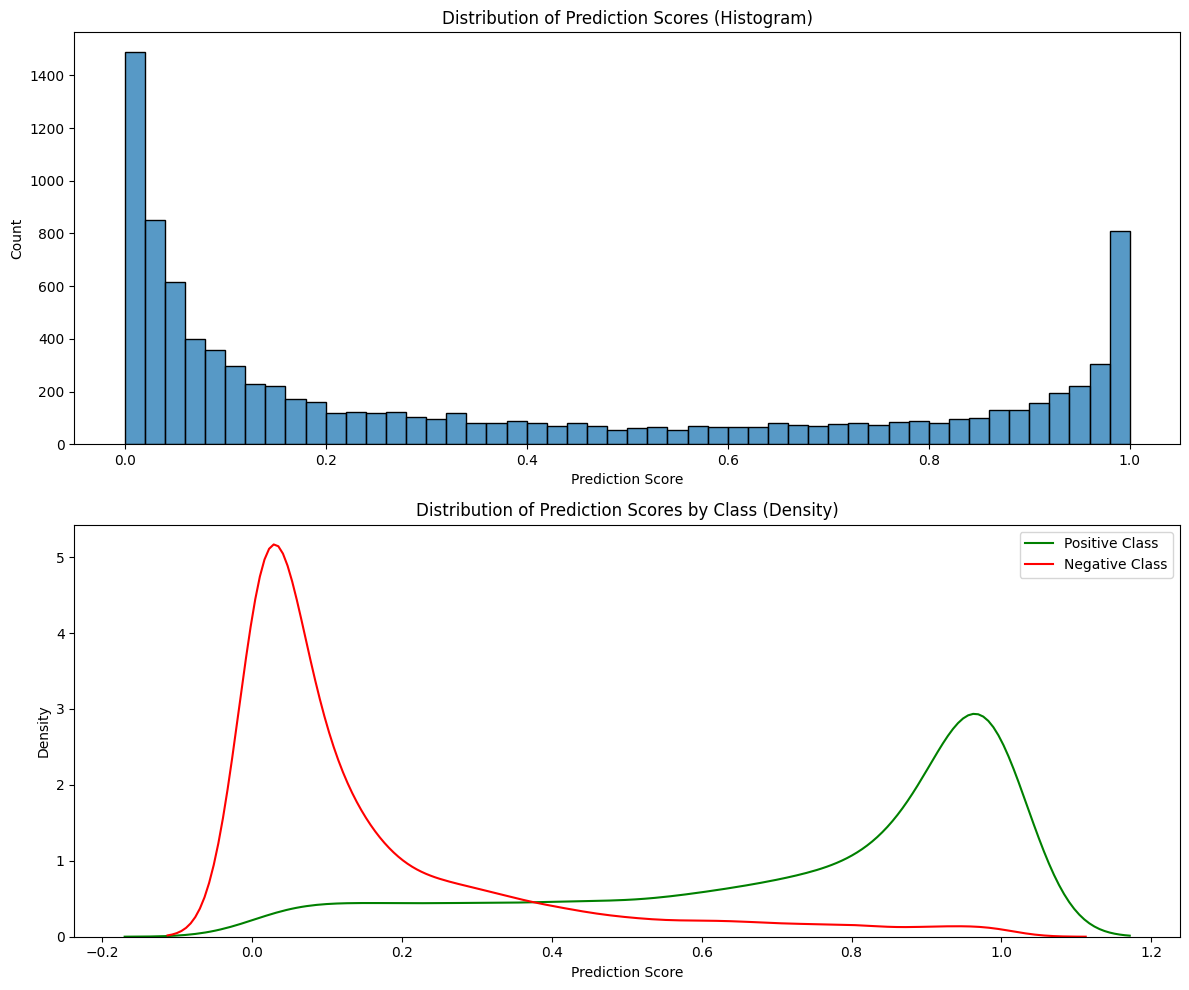


Prediction Score Statistics:
Mean: 0.374
Median: 0.194
Std Dev: 0.373
Min: 0.000
Max: 1.000


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Histogram
sns.histplot(
    data=test_predictions,
    bins=50,
    ax=ax1
)
ax1.set_title('Distribution of Prediction Scores (Histogram)')
ax1.set_xlabel('Prediction Score')
ax1.set_ylabel('Count')

# Separate distributions for positive and negative classes
sns.kdeplot(
    data=test_predictions[y_test == 1],
    ax=ax2,
    label='Positive Class',
    color='green'
)
sns.kdeplot(
    data=test_predictions[y_test == 0],
    ax=ax2,
    label='Negative Class',
    color='red'
)
ax2.set_title('Distribution of Prediction Scores by Class (Density)')
ax2.set_xlabel('Prediction Score')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nPrediction Score Statistics:")
print(f"Mean: {test_predictions.mean():.3f}")
print(f"Median: {np.median(test_predictions):.3f}")
print(f"Std Dev: {test_predictions.std():.3f}")
print(f"Min: {test_predictions.min():.3f}")
print(f"Max: {test_predictions.max():.3f}")

## Full Matrix predictions

Maya creates a heatmap to visualize prediction scores for a random sample of drug-disease pairs, providing insights into the model's predictions.


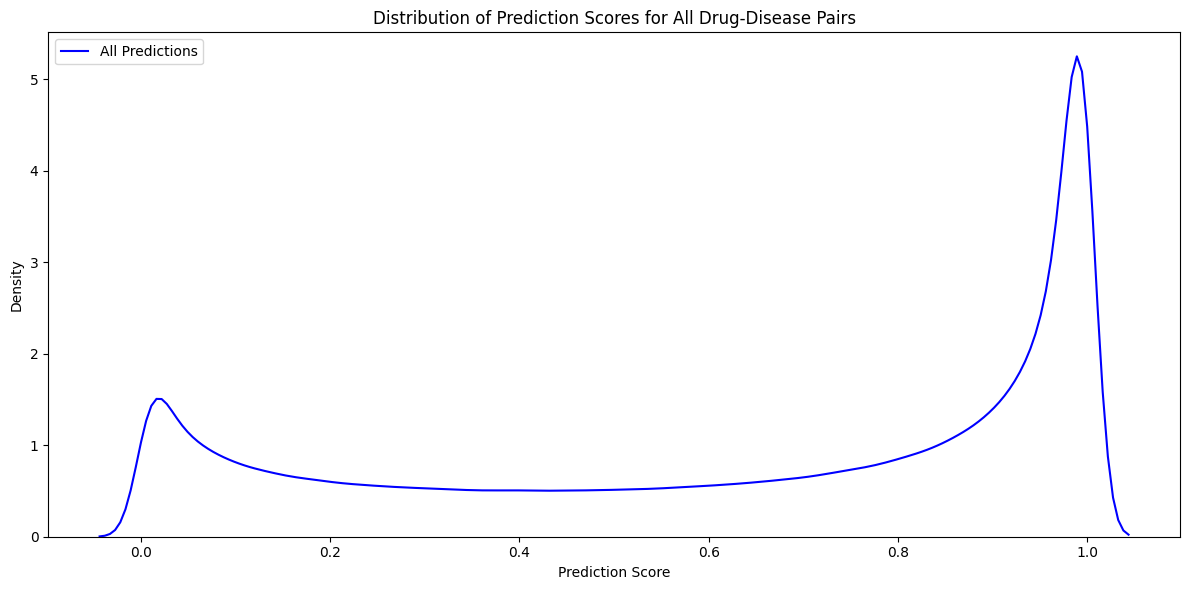


Prediction Score Statistics for All Pairs:
Mean: 0.627
Median: 0.749
Std Dev: 0.350
Min: 0.000
Max: 1.000
Total number of predictions: 7,984,456


In [48]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Overall distribution of all predictions
sns.kdeplot(
    data=results_df['prediction_score'],
    ax=ax,
    label='All Predictions',
    color='blue'
)

ax.set_title('Distribution of Prediction Scores for All Drug-Disease Pairs')
ax.set_xlabel('Prediction Score')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()

# Print basic statistics for all predictions
print("\nPrediction Score Statistics for All Pairs:")
print(f"Mean: {results_df['prediction_score'].mean():.3f}")
print(f"Median: {results_df['prediction_score'].median():.3f}")
print(f"Std Dev: {results_df['prediction_score'].std():.3f}")
print(f"Min: {results_df['prediction_score'].min():.3f}")
print(f"Max: {results_df['prediction_score'].max():.3f}")
print(f"Total number of predictions: {len(results_df):,}")

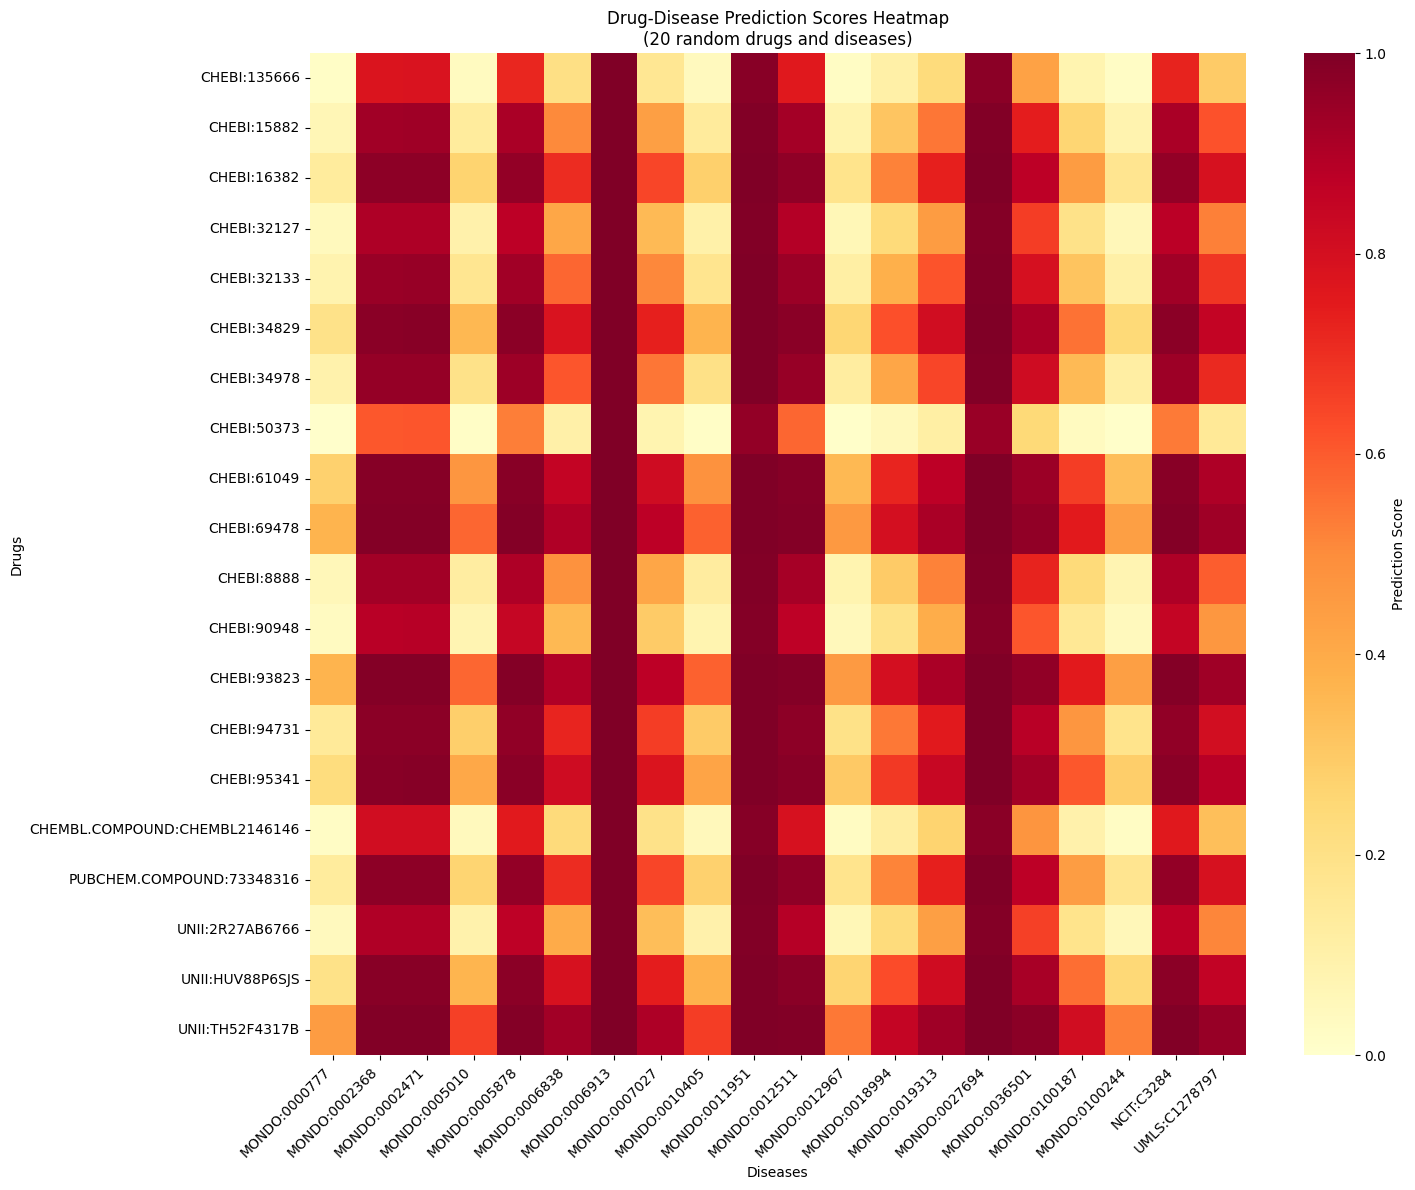


Sample Prediction Statistics:
Mean: 0.634
Median: 0.753
Std Dev: 0.346


In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Randomly sample 20 drugs and 20 diseases
np.random.seed(42)
sample_drugs = np.random.choice(all_drugs, size=20, replace=False)
sample_diseases = np.random.choice(all_diseases, size=20, replace=False)

# Filter results for sampled drugs and diseases
sample_results = results_df[
    results_df['source'].isin(sample_drugs) & 
    results_df['target'].isin(sample_diseases)
]

# Create prediction matrix
pred_matrix = sample_results.pivot(
    index='source', 
    columns='target', 
    values='prediction_score'
)

# Create heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(
    pred_matrix,
    cmap='YlOrRd',
    center=0.5,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Prediction Score'}
)
plt.title('Drug-Disease Prediction Scores Heatmap\n(20 random drugs and diseases)')
plt.xlabel('Diseases')
plt.ylabel('Drugs')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print some statistics about the sampled predictions
print("\nSample Prediction Statistics:")
print(f"Mean: {sample_results['prediction_score'].mean():.3f}")
print(f"Median: {sample_results['prediction_score'].median():.3f}")
print(f"Std Dev: {sample_results['prediction_score'].std():.3f}")

## Evaluation conclusion

Maya generated a full matrix of drug-disease treatment efficacy scores.

We already can see that the model is far from perfect, and it highlights some of the issues our more advanced models has ran into - many drugs and diseases are "frequent flyers" with consistently high scores all across the board. She can also see that many too many drugs-disease pairs have treat scored close to 1.

However, her model is only a basic logistic regression, and for the sake of this exercise we will not be focusing on improving the results she's obrained. 

Now Maya will add her new model as Kedro node.



